In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pprint
import os
import community as community_louvain
import matplotlib.cm as cm
import seaborn as sns
from termcolor import colored
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from scipy.stats import mannwhitneyu

In [2]:
nodes_df = pd.read_csv('marvel_characters_communities.csv')
g = nx.read_gexf('marvel-characters.gexf')

In [3]:
np.where(nodes_df.characterID.duplicated())

(array([85]),)

In [4]:
nodes_df[nodes_df['characterID'] == 1009477]
nodes_df.drop(85, inplace=True)

In [5]:
np.where(nodes_df.Name.duplicated())

(array([32]),)

In [6]:
nodes_df[nodes_df['Name'] == 'Jean Grey']
nodes_df.drop(32, inplace=True)
nodes_df.reset_index(inplace=True, drop=True)

In [7]:
nodes_df.head(3)

,characterID,Name,Alignment,Intelligence,Strength,Speed,Durability,Power,Combat,Total,modularity_class
0,1009220,Captain America,good,63,19,35,56,46,100,319,0
1,1010740,Winter Soldier,good,56,32,35,65,60,84,332,0
2,1009471,Nick Fury,good,75,11,23,42,25,100,276,0


In [8]:
len(nodes_df.Name.unique()), len(nodes_df.characterID.unique())

(196, 196)

In [9]:
nodes_df.set_index('Name', inplace=True)

In [10]:
module_indices = nodes_df.modularity_class.value_counts().index
module_counts = nodes_df.modularity_class.value_counts().values

In [11]:
minority_class_characters = nodes_df[~nodes_df['modularity_class'].isin(module_indices[:2])].index.tolist()

In [12]:
nodes_df.drop(minority_class_characters, inplace=True)

In [13]:
g.remove_nodes_from(minority_class_characters)

In [14]:
module_indices

Int64Index([0, 3, 1, 2], dtype='int64')

In [15]:
nodes_df.replace(3, 1, inplace=True)

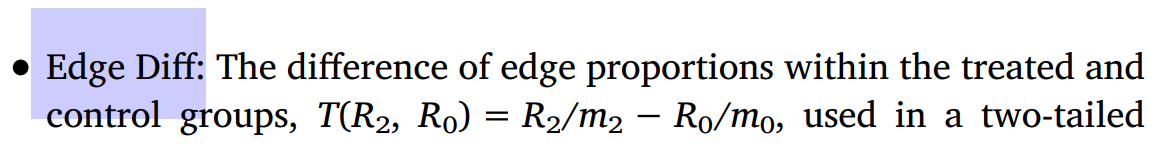

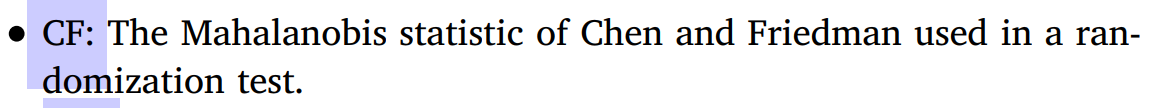

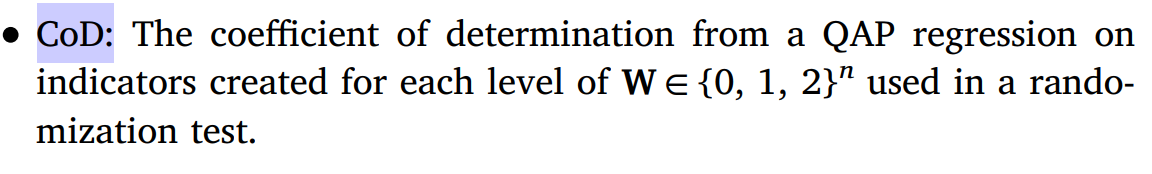

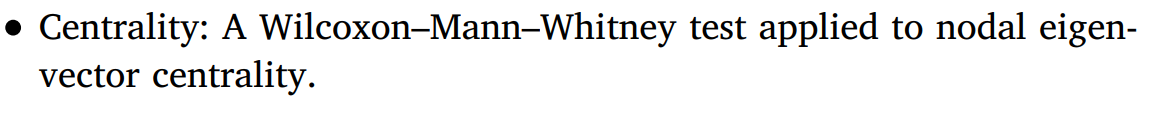

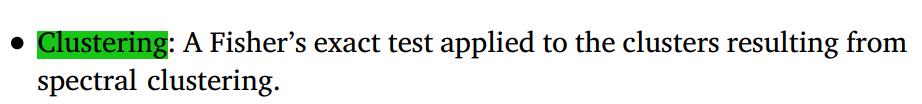

In [16]:
class Permutation_tests:
    def __init__(self, g, nodes_df):
        self.g = g
        self.nodes_df = nodes_df
        
    def mannwhitneyu_test(self, nodes_df, target_column, target_value): 
        group_statistics = [[], []]
        for character, score in nx.eigenvector_centrality(self.g).items():
            group_statistics[nodes_df.loc[character][target_column]].append(score)
        statistic, p_value = mannwhitneyu(group_statistics[0], group_statistics[1])
        return statistic
        
    def within_group_edges_statistic(self, nodes_df, target_column, target_value):
        statistic = 0
        for edge in self.g.edges():
            src = edge[0]
            trg = edge[1]
            if (nodes_df.loc[src][target_column] == nodes_df.loc[trg][target_column] == target_value):
                statistic += 1
        return statistic / 2

    def edge_diff_statistic(self, nodes_df, target_column, target_values):
        group_statistics = [0, 0, 0]
        for edge in self.g.edges(): 
            src = edge[0]
            trg = edge[1]
            for value in target_values:
                group_statistics[nodes_df.loc[src][target_column] + nodes_df.loc[trg][target_column]] += 1
        n0 = len(nodes_df[nodes_df[target_column] == 0])
        n1 = len(nodes_df[nodes_df[target_column] == 1])
        m0 = n0 * (n0 - 1) / 2
        m2 = n1 * (n1 - 1) / 2
        m1 = n1 * n0
        return group_statistics[0] / m0 - group_statistics[2] / m2
    
    def cf_statistic(self, nodes_df, target_column, target_values):   
        group_statistics = [0, 0, 0]
        for edge in self.g.edges(): 
            src = edge[0]
            trg = edge[1]
            for value in target_values:
                group_statistics[nodes_df.loc[src][target_column] + nodes_df.loc[trg][target_column]] += 1
        n0 = len(nodes_df[nodes_df[target_column] == 0])
        n1 = len(nodes_df[nodes_df[target_column] == 1])
        n = len(self.g.nodes)
        m0 = n0 * (n0 - 1) / 2
        m2 = n1 * (n1 - 1) / 2
        m1 = n1 * n0
        R0 = group_statistics[0]
        R1 = group_statistics[1]
        R2 = group_statistics[2]
        R = len(self.g.edges)
        di = np.array([a[1] for a in list(nx.degree(self.g))])
        C = np.sum(di**2) - np.sum(di)
        
        mu2 = R * n1 * (n1 - 1) / n / (n - 1)
        mu0 = R * n0 * (n0 - 1) / n / (n - 1)
        
        sigma22 = mu2*(1-mu2) + C*n1*(n1-1)*(n1-2)/n/(n-1)/(n-2) + (R*(R-1)-C)*n1*(n1-1)*(n1-2)*(n1-3)/n/(n-1)/(n-2)/(n-3)
        sigma02 = mu0*(1-mu0) + C*n0*(n0-1)*(n0-2)/n/(n-1)/(n-2) + (R*(R-1)-C)*n0*(n0-1)*(n0-2)*(n0-3)/n/(n-1)/(n-2)/(n-3)
        sigma20 = (R*(R-1)-C)*n0*n1*(n1-1)*(n0-1)/n/(n-1)/(n-2)/(n-3) - mu2*mu0
        A = np.array([[R2 - mu2], 
                      [R0 - mu0]])
        cov_matrix = np.array([[sigma22, sigma20], 
                               [sigma20, sigma02]])
        cf_statitic = np.dot(np.dot(A.T, np.linalg.inv(cov_matrix)), A)
        return cf_statitic[0][0]
                
    
    def do_test(self, target_column, target_value, n_permutations, test): 
        observed_value = test(self, self.nodes_df, target_column, target_value)
        nodes_df_temp = self.nodes_df.copy()
        permutated_values = []
        for i in tqdm(range(n_permutations)):
            nodes_df_temp[target_column] = np.random.permutation(nodes_df_temp[target_column])
            permutated_values.append(test(self, nodes_df_temp, target_column, target_value))
            
        permutated_values = np.array(permutated_values)
        p_value = len(np.where(permutated_values > observed_value)[0]) / n_permutations
        p_value_ = round(1 - p_value, ndigits=3)
        print(p_value)
        print(p_value_)
        p_value = min(p_value, p_value_)
        return observed_value, permutated_values, p_value
p = Permutation_tests(g, nodes_df)

### Mannwhitneyu Test

100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


0.8
0.2


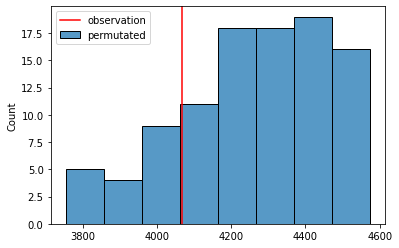

In [17]:
observed_value, permutated_values, p_value = p.do_test('modularity_class', None, 100, Permutation_tests.mannwhitneyu_test)
sns.histplot(permutated_values, label='permutated')
plt.axvline(x=observed_value, color='red', label='observation')
plt.legend()

### cf statistic

100%|██████████| 100/100 [09:40<00:00,  5.80s/it]

0.0
1.0


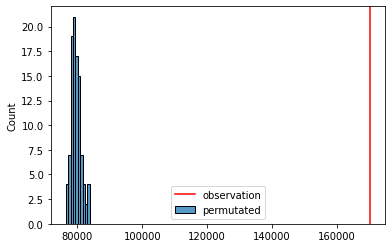

In [18]:
observed_value, permutated_values, p_value = p.do_test('modularity_class', [0, 1, 2], 100, Permutation_tests.cf_statistic)
sns.histplot(permutated_values, label='permutated')
plt.axvline(x=observed_value, color='red', label='observation')
plt.legend()

### edge diff statistic

100%|██████████| 100/100 [09:54<00:00,  5.94s/it]

0.99
0.01


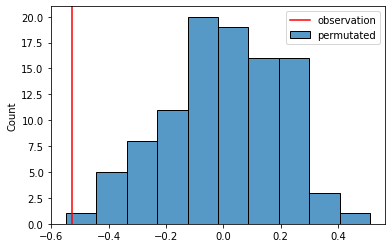

In [19]:
observed_value, permutated_values, p_value = p.do_test('modularity_class', [0, 1, 2], 100, Permutation_tests.edge_diff_statistic)
sns.histplot(permutated_values, label='permutated')
plt.axvline(x=observed_value, color='red', label='observation')
plt.legend()

### normal statistic

100%|██████████| 100/100 [03:27<00:00,  2.08s/it]

0.05
0.95


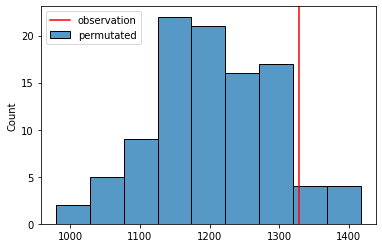

In [20]:
observed_value, permutated_values, p_value = p.do_test('modularity_class', 0, 100, Permutation_tests.within_group_edges_statistic)
sns.histplot(permutated_values, label='permutated')
plt.axvline(x=observed_value, color='red', label='observation')
plt.legend()

100%|██████████| 100/100 [03:31<00:00,  2.12s/it]

0.0
1.0


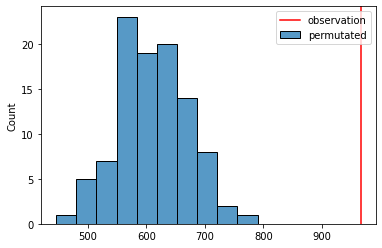

In [21]:
observed_value, permutated_values, p_value = p.do_test('modularity_class', 1, 100, Permutation_tests.within_group_edges_statistic)
sns.histplot(permutated_values, label='permutated')
plt.axvline(x=observed_value, color='red', label='observation')
plt.legend()

In [22]:
import scipy.stats as stats

In [23]:
highest_betweenness = {key: value for key, value in sorted(nx.betweenness_centrality(g).items(), key=lambda x: x[1], reverse=True)}

### Spectral Clustering


In [24]:
def compute_size_of_cluster_group(**args):
    nodes_df = args['nodes_df']
    cluster = args['cluster']
    group = args['group']
    labels = args['labels']
    labels_names = set(nodes_df.iloc[np.where(labels == cluster)[0]].index.tolist())
    group_names = set(nodes_df[nodes_df['modularity_class'] == group].index.tolist())
    return len(set.intersection(labels_names, group_names))

In [25]:
from sklearn.cluster import SpectralClustering
import scipy.stats as stats

sc = SpectralClustering(2, affinity='precomputed', n_init=100, assign_labels='discretize')

adj_matrix = nx.to_numpy_matrix(g)
sc.fit_predict(adj_matrix)
labels = sc.labels_


control_1 = compute_size_of_cluster_group(nodes_df=nodes_df, labels=labels, group=0, cluster=1)
control_0 = compute_size_of_cluster_group(nodes_df=nodes_df, labels=labels, group=0, cluster=0)
treatment_1 = compute_size_of_cluster_group(nodes_df=nodes_df, labels=labels, group=1, cluster=1)
treatment_0 = compute_size_of_cluster_group(nodes_df=nodes_df, labels=labels, group=1, cluster=0)

result_array = np.array([[control_1, treatment_1], 
                         [control_0, treatment_0]])

print(result_array)


oddsratio, pvalue = stats.fisher_exact(result_array)
pvalue

[[42 36]
 [71 45]]


0.37317586474867953